# Import RPB model along with other utility functions

In [1]:
from RPB_model import *

expression symbols from pyomo.core.expr  (deprecated in 6.6.2.dev0) (called
from <frozen importlib._bootstrap>:241)


# Creating model for a single side/section of the RPB

In [2]:
# Create model instance. Currently, mode can be either "adsorption" or "desorption" which sets the boundary conditions for each case.
# m=RPB_model(mode="adsorption")
# or
m=RPB_model(mode="desorption")

# Custom initialization routine. Uses a homotopy routine to adjust the initialization factors so that all equations are 'active'.
homotopy_init_routine(m)


Fixing boundaries to make square problem
DOF = 0
Ipopt 3.13.2: output_file=C:\Users\hughesr\AppData\Local\Temp\tmpeid_rlk6ipopt_out
max_iter=100
max_cpu_time=60


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT mu

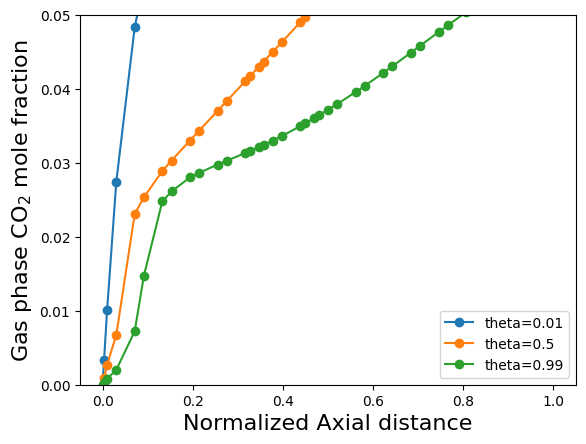

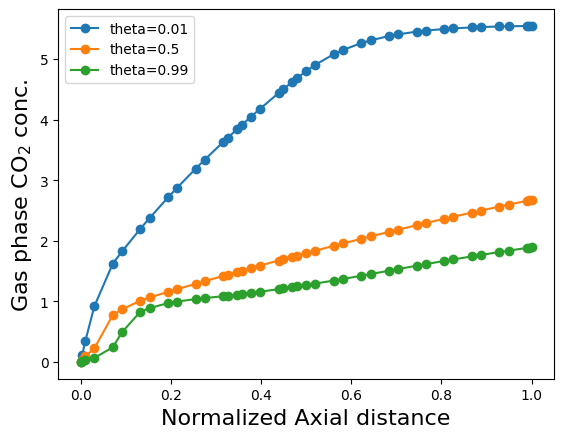

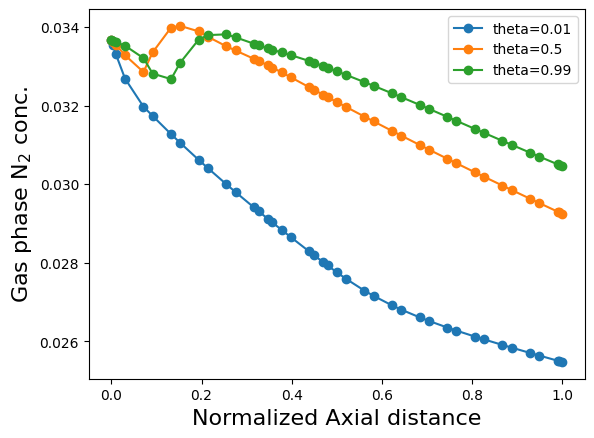

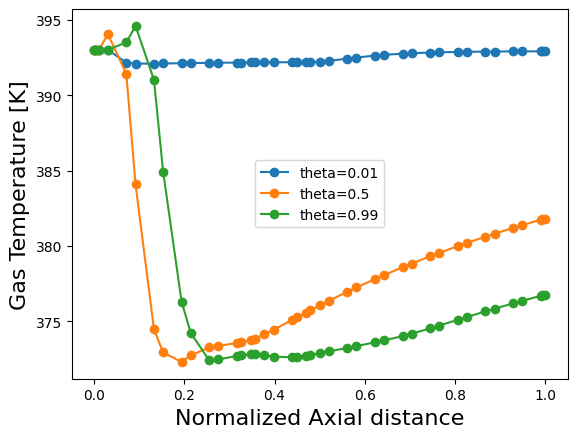

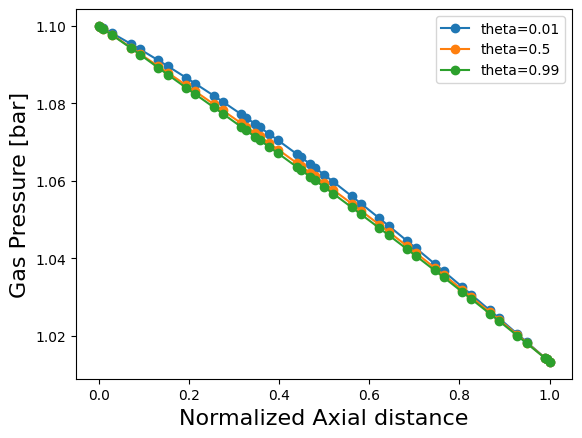

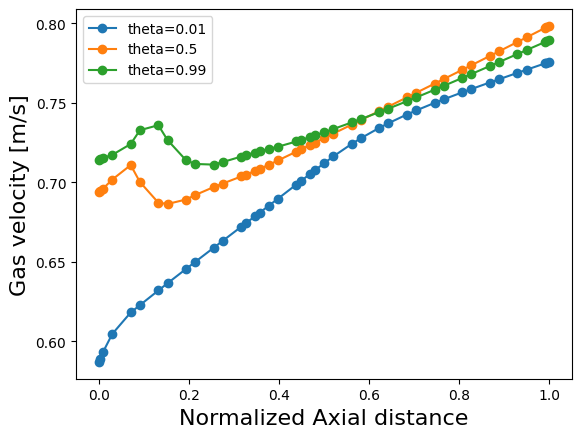

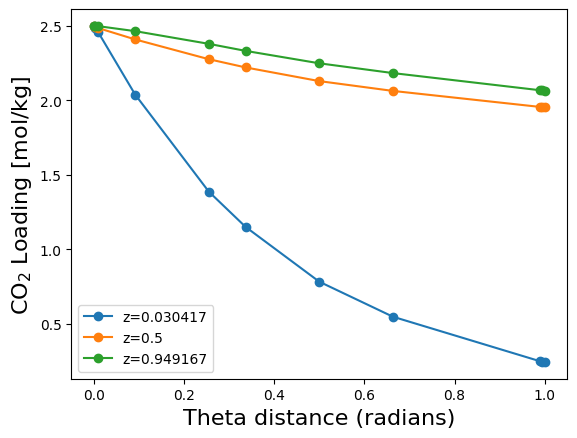

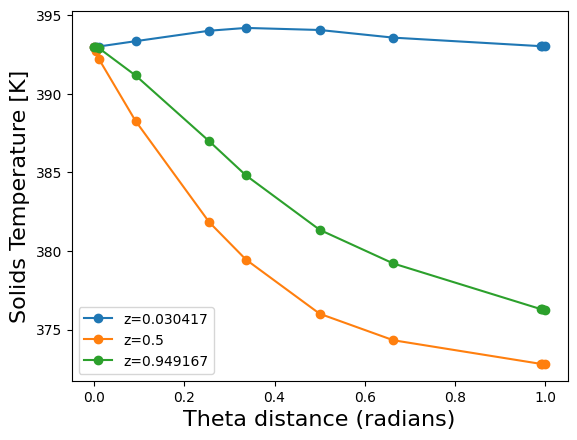

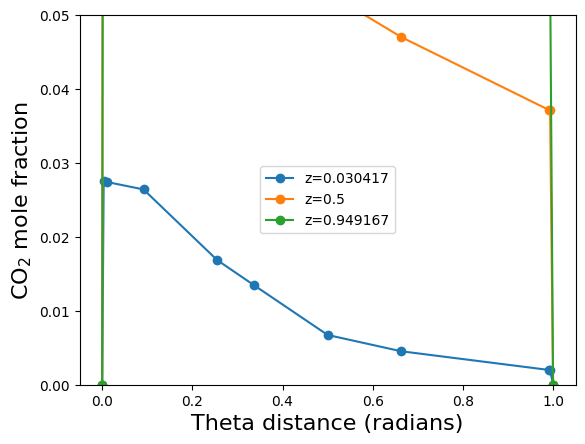

In [3]:
# Plotting the results/profiles

plotting(m)

In [4]:
# Some various utility functions that I have been using to check model performance
evaluate_RPB_error(m)

print(f'CO2 Capture = {m.CO2_capture():.3}')

# check_scaling(m)

# degen_hunter(m)

# jac, variables, constraints = scaling_script(m)

N2 error = 4.44e-14 %
CO2 error = 5.08 %
H2O error = -2.22e-14 %
CO2 Capture = -1.31e+04


# Creating a full RPB model

Initialization Method 1

In [5]:
RPB = ConcreteModel()

RPB.ads = RPB_model(mode="adsorption")
RPB.des = RPB_model(mode="desorption")

In [6]:
# fix BCs
RPB.ads.P_in.fix(1.1)
RPB.ads.Tg_in.fix()
RPB.ads.y_in.fix()
RPB.ads.P_out.fix(1.01325)

RPB.des.P_in.fix(1.1)
RPB.des.Tg_in.fix()
RPB.des.y_in.fix()
RPB.des.P_out.fix(1.01325)

In [7]:
# connect rich stream
# unfix inlet loading and temperature to the desorption section. (No mass transfer at boundaries so z=0 and z=1 need to remain fixed.)
for z in RPB.des.z:
    if z!=0 and z!=1:
        RPB.des.qCO2_in[z].unfix()
        RPB.des.Ts_in[z].unfix()

# add equality constraint equating inlet desorption loading to outlet adsorption loading. Same for temperature.
@RPB.Constraint(RPB.des.z)
def rich_loading_constraint(RPB,z):
    if z==0 or z==1:
        return Constraint.Skip
    else:
        return RPB.des.qCO2_in[z] == RPB.ads.qCO2[z,1]

@RPB.Constraint(RPB.des.z)
def rich_temp_constraint(RPB,z):
    if z==0 or z==1:
        return Constraint.Skip
    else:
        return 1e-2*RPB.des.Ts_in[z] == 1e-2*RPB.ads.Ts[z,1]

In [8]:
# connect lean stream
# unfix inlet loading to the adsorption section
for z in RPB.ads.z:
    if z!=0 and z!=1:
        RPB.ads.qCO2_in[z].unfix()

# add equality constraint equating inlet adsorption loading to outlet desorption loading
@RPB.Constraint(RPB.ads.z)
def lean_loading_constraint(RPB,z):
    if z==0 or z==1:
        return Constraint.Skip
    else:
        return RPB.des.qCO2[z,1] == RPB.ads.qCO2_in[z]

In [9]:
# create Block init object
init_obj = BlockTriangularizationInitializer()

init_obj.config.block_solver_call_options = {"tee": True}
# init_obj.config.block_solver_options = {"halt_on_ampl_error": "yes"}

In [10]:
# turn on solids mass transfer (with the loadings connected at the rich and lean ends, solids mass transfer has to be turned on or no solution exists)
RPB.ads.R_MT_solid = 1
RPB.des.R_MT_solid = 1

In [11]:
# run initialization routine

init_obj.initialization_routine(RPB)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [12]:
# now turn on the other equations using the homotopy routine

variables_list = [
    RPB.ads.R_MT_gas,
    RPB.des.R_MT_gas,
    RPB.ads.R_MT_coeff,
    RPB.des.R_MT_coeff,
    RPB.ads.R_HT_ghx,
    RPB.des.R_HT_ghx,
    RPB.ads.R_HT_gs,
    RPB.des.R_HT_gs,
    RPB.ads.R_delH,
    RPB.des.R_delH,
]

targets_list = [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]


homotopy(
    RPB,
    variables_list,
    targets_list,
    max_solver_iterations=100,
    max_solver_time=60,
    min_step=0.01,
    iter_target=8,
)

Ipopt 3.13.2: output_file=C:\Users\hughesr\AppData\Local\Temp\tmpz1ged1kvipopt_out
max_iter=100
max_cpu_time=60


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
    

(<TerminationCondition.optimal: 'optimal'>, 1.0, 19)

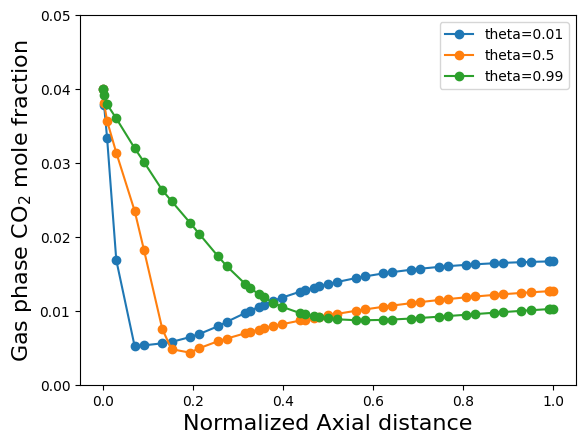

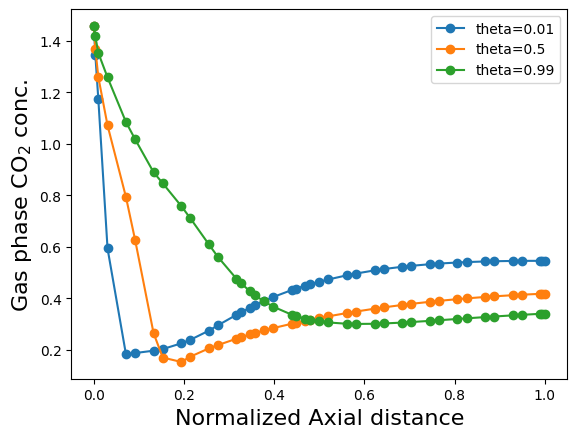

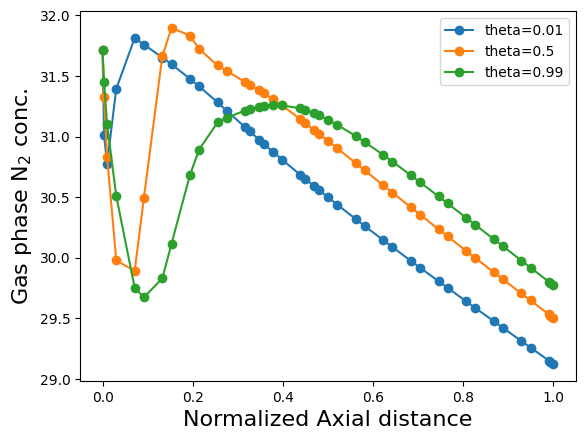

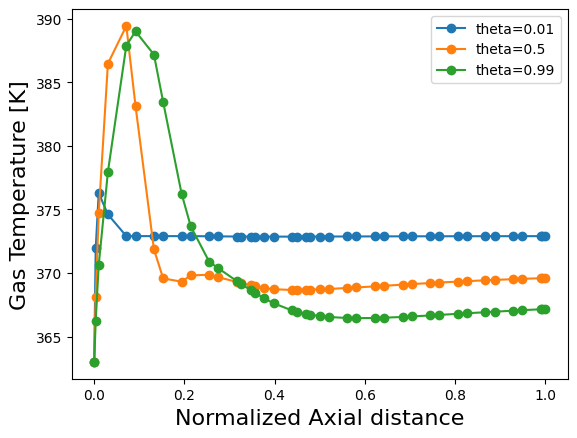

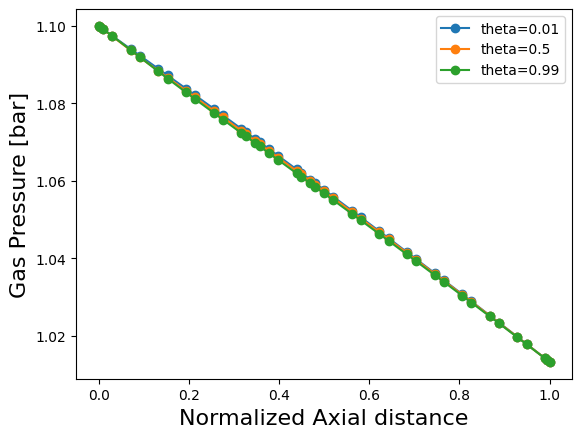

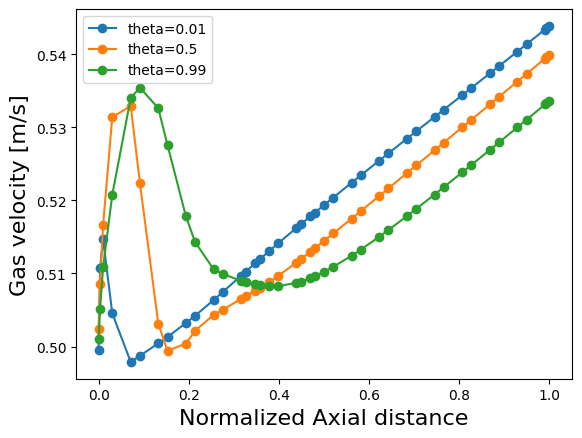

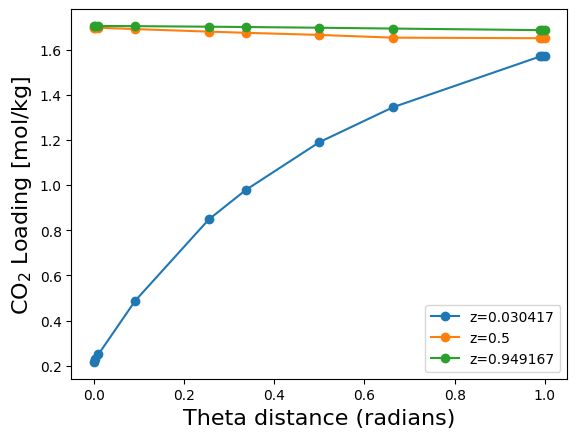

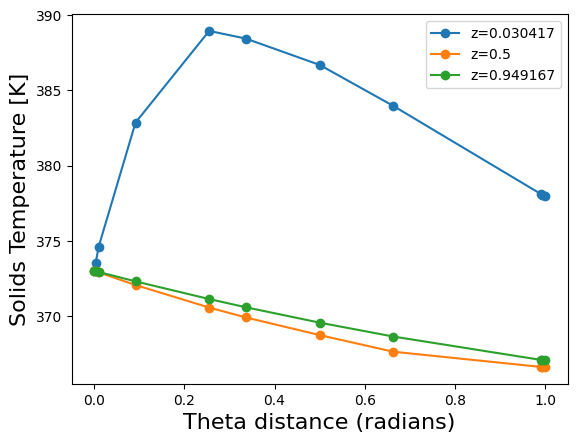

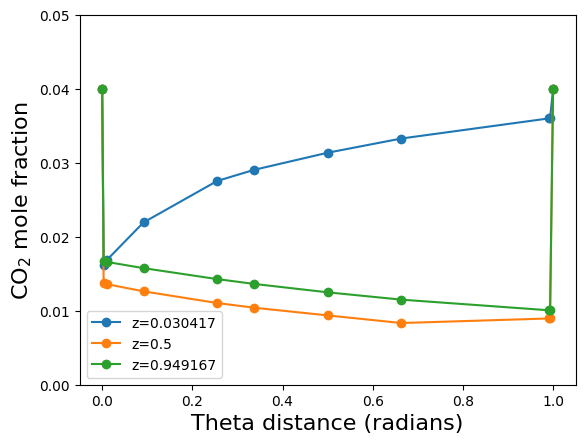

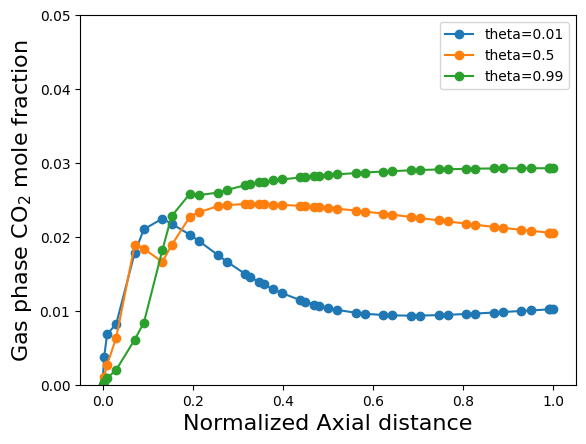

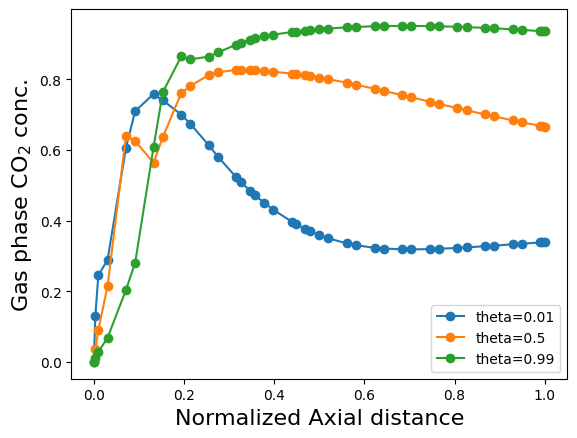

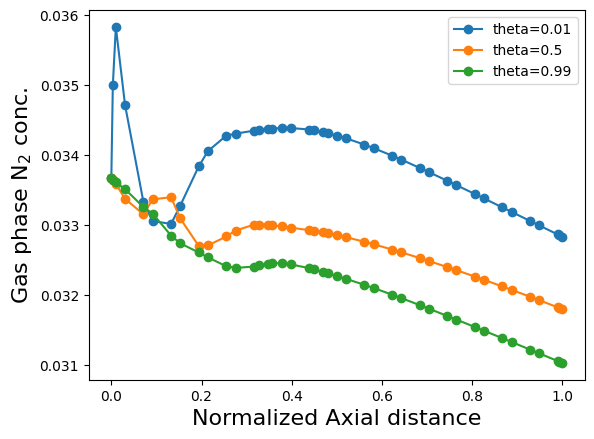

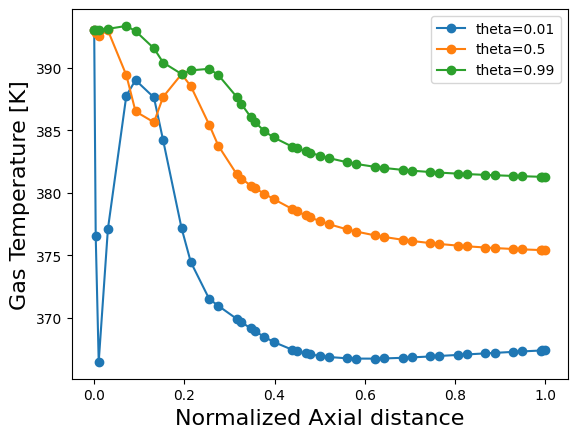

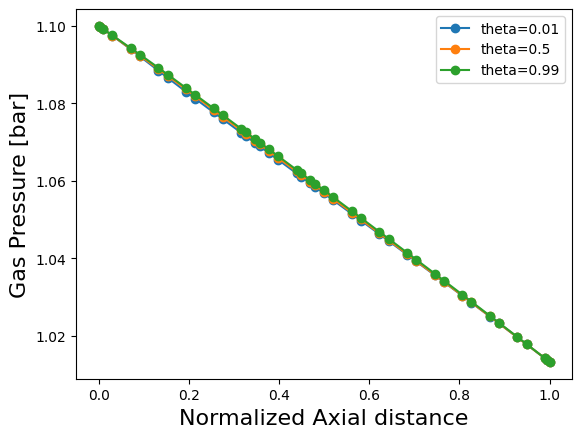

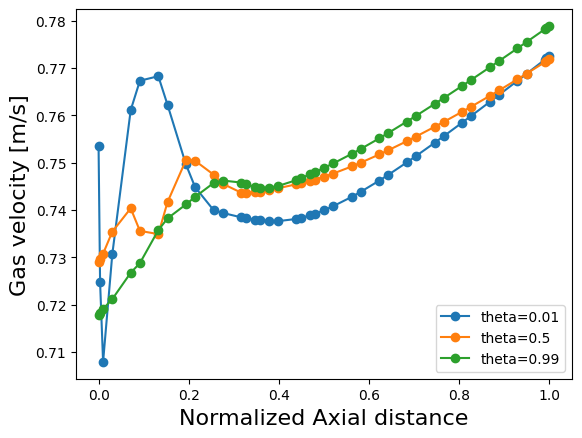

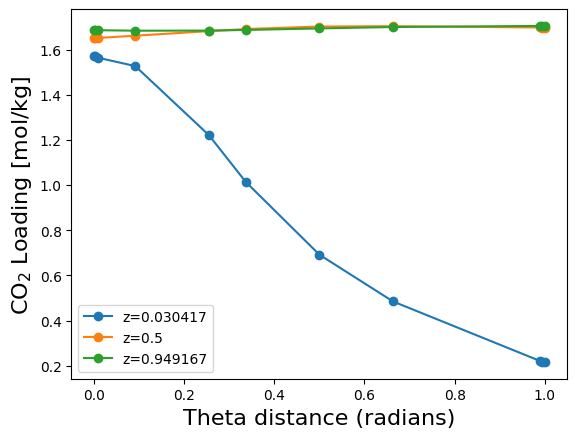

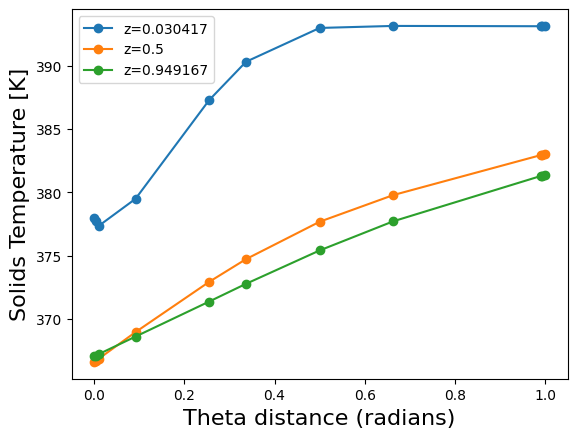

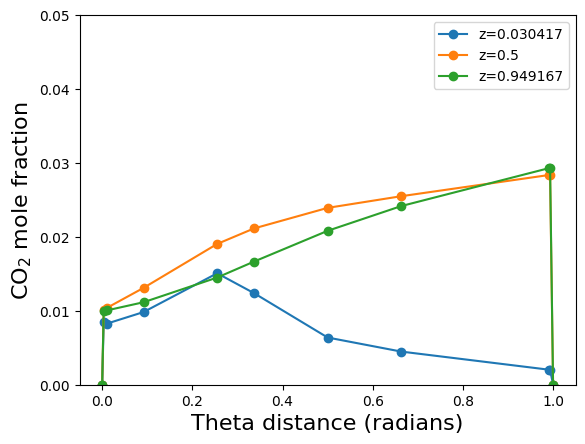

In [13]:
# plotting results

plotting(RPB.ads)

# and/or 

plotting(RPB.des)

Initialization Method 2

In [14]:
RPB = ConcreteModel()

RPB.ads = RPB_model(mode="adsorption")
RPB.des = RPB_model(mode="desorption")

In [15]:
# fix BCs
RPB.ads.P_in.fix(1.1)
RPB.ads.Tg_in.fix()
RPB.ads.y_in.fix()
RPB.ads.P_out.fix(1.01325)

RPB.des.P_in.fix(1.1)
RPB.des.Tg_in.fix()
RPB.des.y_in.fix()
RPB.des.P_out.fix(1.01325)

In [16]:
# connect rich stream
# unfix inlet loading and temperature to the desorption section. (No mass transfer at boundaries so z=0 and z=1 need to remain fixed.)
for z in RPB.des.z:
    if z!=0 and z!=1:
        RPB.des.qCO2_in[z].unfix()
        RPB.des.Ts_in[z].unfix()

# add equality constraint equating inlet desorption loading to outlet adsorption loading. Same for temperature.
@RPB.Constraint(RPB.des.z)
def rich_loading_constraint(RPB,z):
    if z==0 or z==1:
        return Constraint.Skip
    else:
        return RPB.des.qCO2_in[z] == RPB.ads.qCO2[z,1]

@RPB.Constraint(RPB.des.z)
def rich_temp_constraint(RPB,z):
    if z==0 or z==1:
        return Constraint.Skip
    else:
        return 1e-2*RPB.des.Ts_in[z] == 1e-2*RPB.ads.Ts[z,1]

In [17]:
# connect lean stream (leaving temperature unconnected for this case, assume a small cooling section)
# unfix inlet loading to the adsorption section
for z in RPB.ads.z:
    if z!=0 and z!=1:
        RPB.ads.qCO2_in[z].unfix()

# add equality constraint equating inlet adsorption loading to outlet desorption loading
@RPB.Constraint(RPB.ads.z)
def lean_loading_constraint(RPB,z):
    if z==0 or z==1:
        return Constraint.Skip
    else:
        return RPB.des.qCO2[z,1] == RPB.ads.qCO2_in[z]

In [18]:
# create Block init object
init_obj = BlockTriangularizationInitializer()

init_obj.config.block_solver_call_options = {"tee": True}
# init_obj.config.block_solver_options = {"halt_on_ampl_error": "yes"}

In [19]:
# turn on solids mass transfer (with the loadings connected at the rich and lean ends, solids mass transfer has to be turned on or no solution exists)
RPB.ads.R_MT_solid = 1
RPB.des.R_MT_solid = 1

In [20]:
# run initialization routine

init_obj.initialization_routine(RPB)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [21]:
# now turn on the other equations step by step and re-run the initialization each time

RPB.ads.R_MT_gas = 1
RPB.des.R_MT_gas = 1
init_obj.initialization_routine(RPB)

RPB.ads.R_MT_coeff = 1
RPB.des.R_MT_coeff = 1
init_obj.initialization_routine(RPB)

RPB.ads.R_HT_ghx = 1
RPB.des.R_HT_ghx = 1
init_obj.initialization_routine(RPB)

RPB.ads.R_HT_gs = 1
RPB.des.R_HT_gs = 1
init_obj.initialization_routine(RPB)

RPB.ads.R_delH = 0.5 # have to add an additional step for delH
RPB.des.R_delH = 0.5
init_obj.initialization_routine(RPB)

RPB.ads.R_delH = 1
RPB.des.R_delH = 1
init_obj.initialization_routine(RPB)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

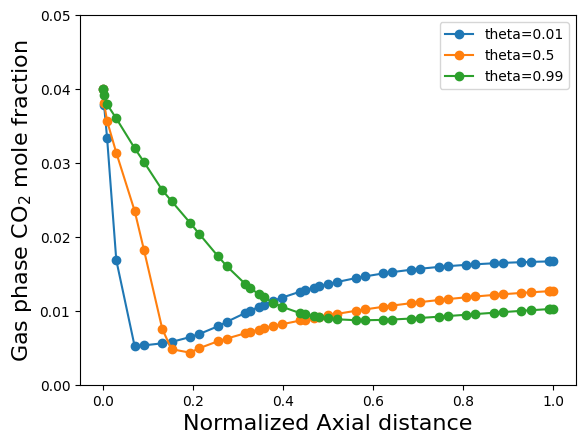

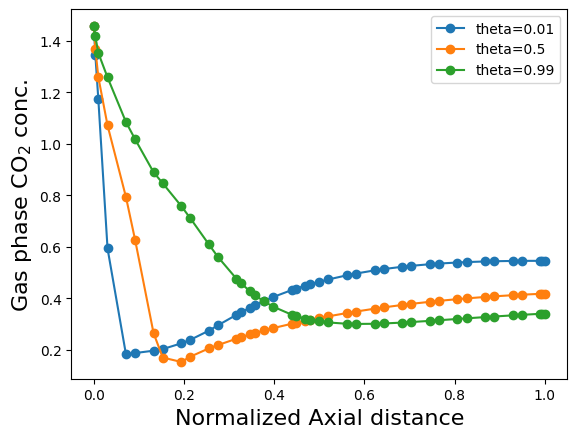

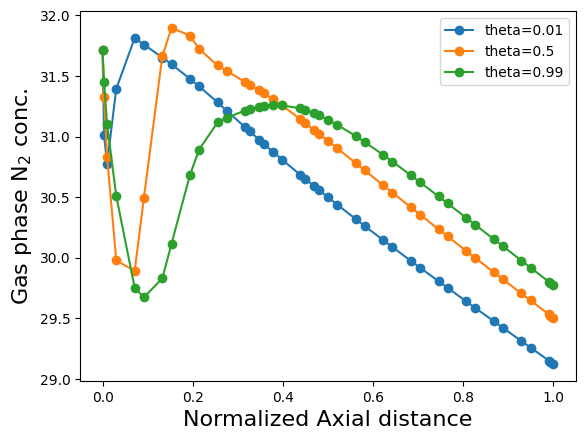

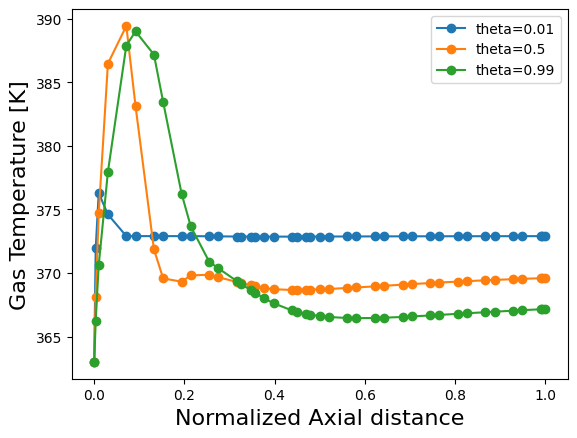

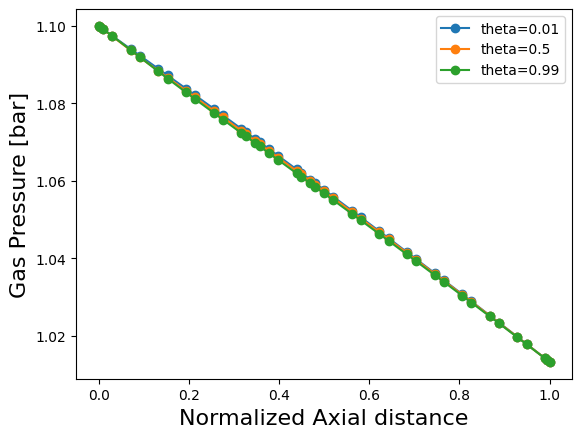

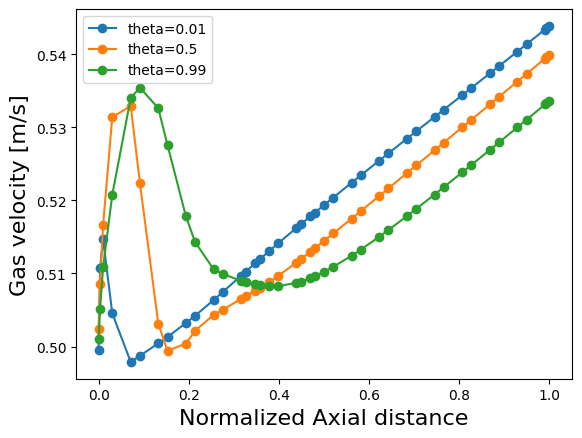

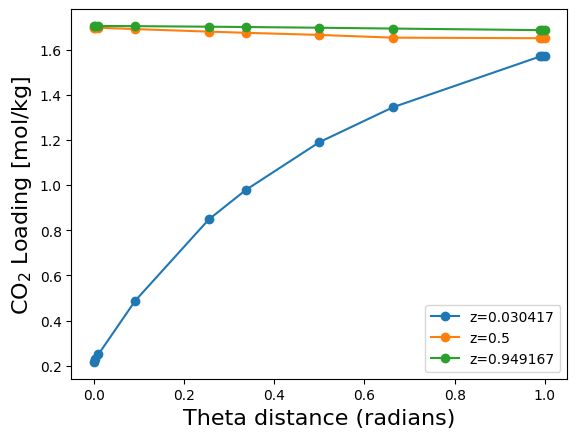

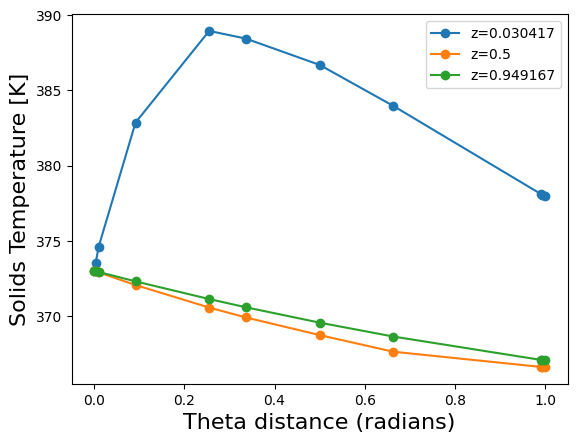

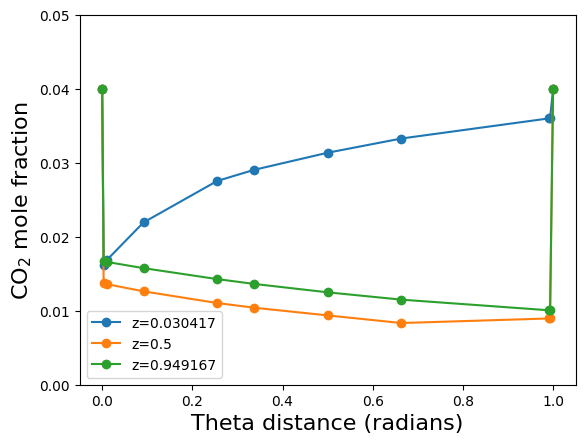

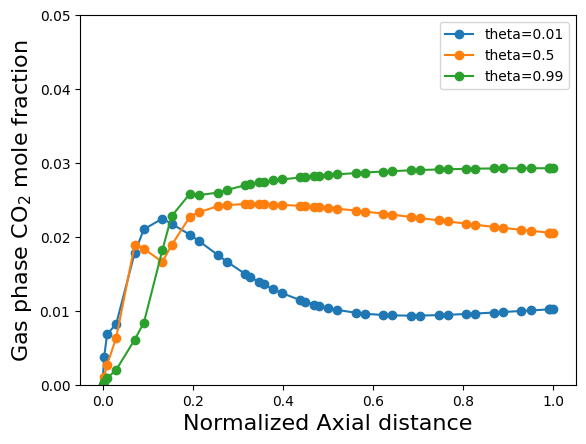

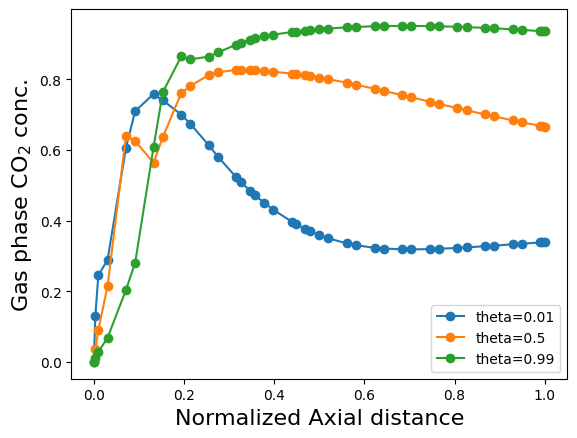

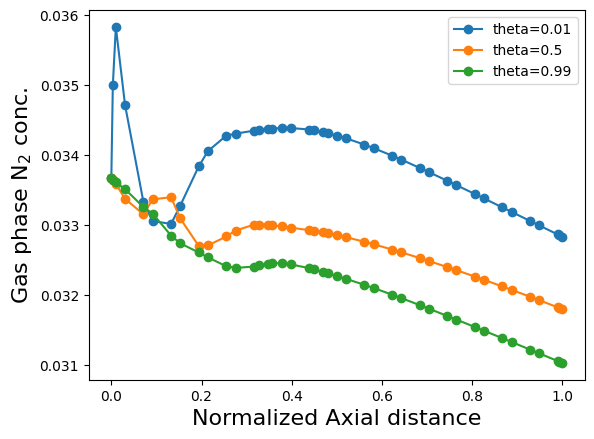

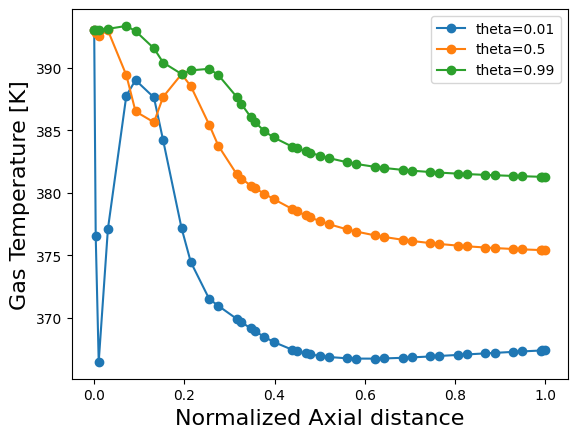

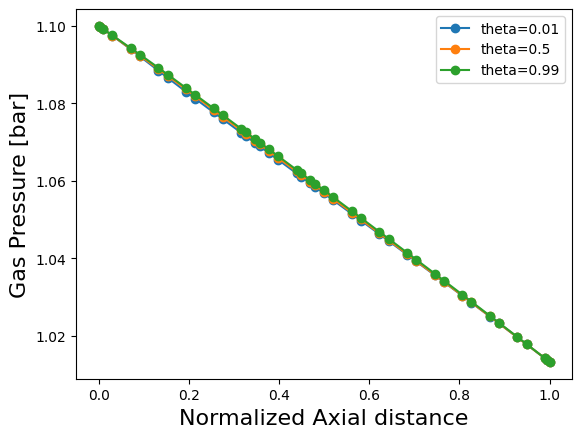

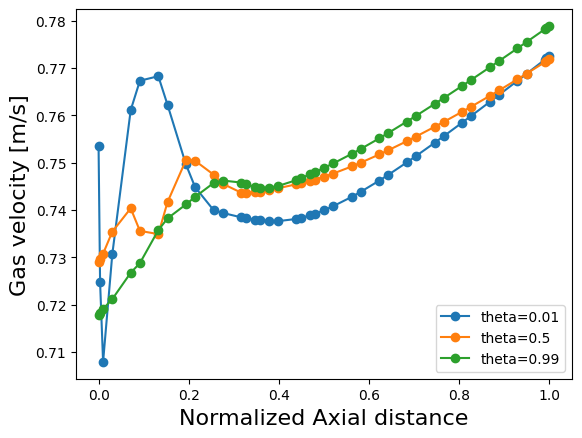

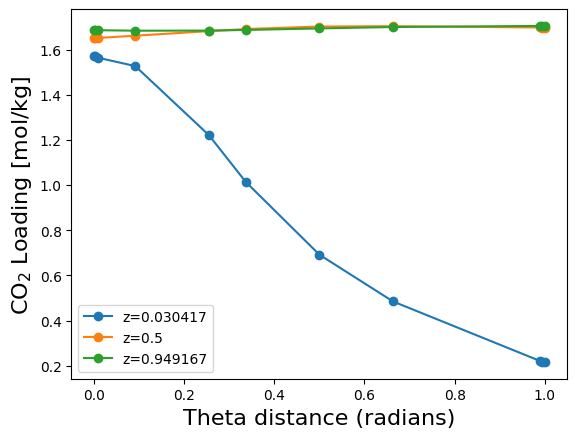

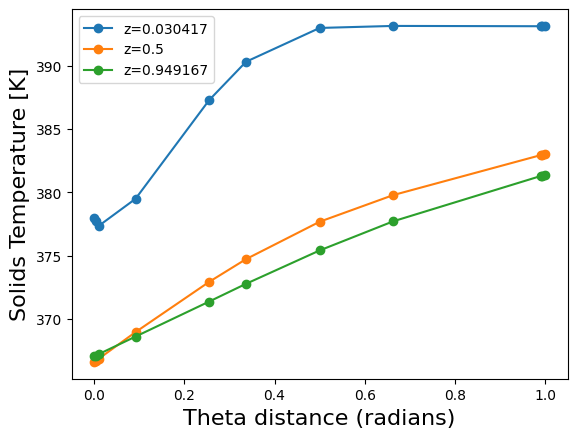

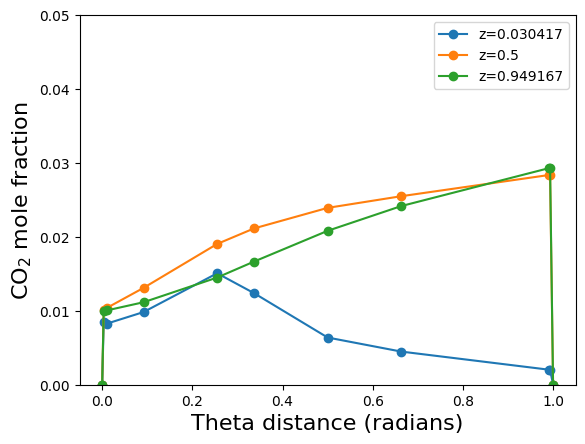

In [22]:
# plotting results

plotting(RPB.ads)

# and/or 

plotting(RPB.des)

# Save and load model

In [23]:
# save model
to_json(RPB, fname="RPB_model.json.gz", gz=True, human_read=False)

In [24]:
# create model, load results, and then solve
RPB = ConcreteModel()

RPB.ads = RPB_model(mode="adsorption")
RPB.des = RPB_model(mode="desorption")

# fix BCs
RPB.ads.P_in.fix(1.1)
RPB.ads.Tg_in.fix()
RPB.ads.y_in.fix()
RPB.ads.P_out.fix(1.01325)

RPB.des.P_in.fix(1.1)
RPB.des.Tg_in.fix()
RPB.des.y_in.fix()
RPB.des.P_out.fix(1.01325)

# connect rich stream
# unfix inlet loading and temperature to the desorption section
for z in RPB.des.z:
    if z!=0 and z!=1:
        RPB.des.qCO2_in[z].unfix()
        RPB.des.Ts_in[z].unfix()

# add equality constraint equating inlet desorption loading to outlet adsorption loading. Same for temperature.
@RPB.Constraint(RPB.des.z)
def rich_loading_constraint(RPB,z):
    if z==0 or z==1:
        return Constraint.Skip
    else:
        return RPB.des.qCO2_in[z] == RPB.ads.qCO2[z,1]

@RPB.Constraint(RPB.des.z)
def rich_temp_constraint(RPB,z):
    if z==0 or z==1:
        return Constraint.Skip
    else:
        return 1e-2*RPB.des.Ts_in[z] == 1e-2*RPB.ads.Ts[z,1]
    
# connect lean stream
# unfix inlet loading to the adsorption section
for z in RPB.ads.z:
    if z!=0 and z!=1:
        RPB.ads.qCO2_in[z].unfix()

# add equality constraint equating inlet adsorption loading to outlet desorption loading
@RPB.Constraint(RPB.ads.z)
def lean_loading_constraint(RPB,z):
    if z==0 or z==1:
        return Constraint.Skip
    else:
        return RPB.des.qCO2[z,1] == RPB.ads.qCO2_in[z]
    
# turn on initialization factors
RPB.ads.R_MT_solid = 1
RPB.des.R_MT_solid = 1
RPB.ads.R_MT_gas = 1
RPB.des.R_MT_gas = 1
RPB.ads.R_MT_coeff = 1
RPB.des.R_MT_coeff = 1
RPB.ads.R_HT_ghx = 1
RPB.des.R_HT_ghx = 1
RPB.ads.R_HT_gs = 1
RPB.des.R_HT_gs = 1
RPB.ads.R_delH = 1
RPB.des.R_delH = 1

from_json(RPB, fname="RPB_model.json.gz", gz=True)

solver = SolverFactory("ipopt")
solver.options = {
    "max_iter": 1000,
    "bound_push": 1e-22,
    "halt_on_ampl_error": "yes",
}
solver.solve(RPB, tee=True).write()

Ipopt 3.13.2: max_iter=1000
bound_push=1e-22
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for l

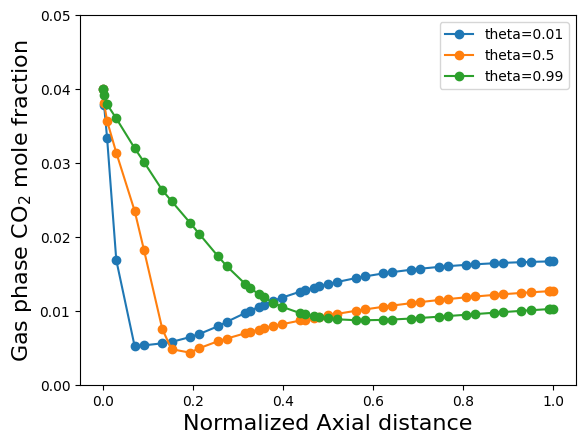

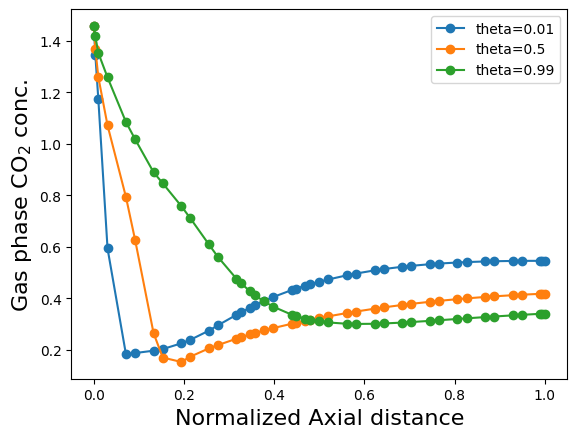

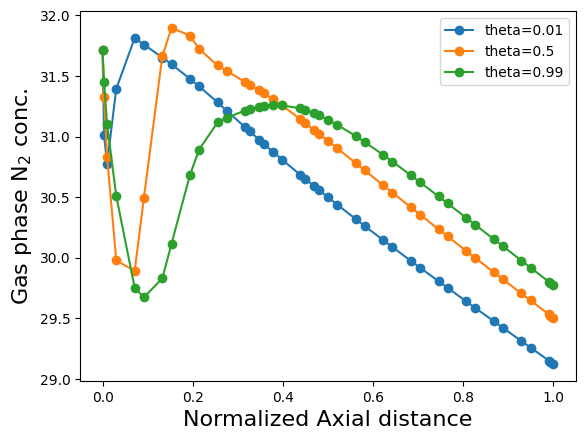

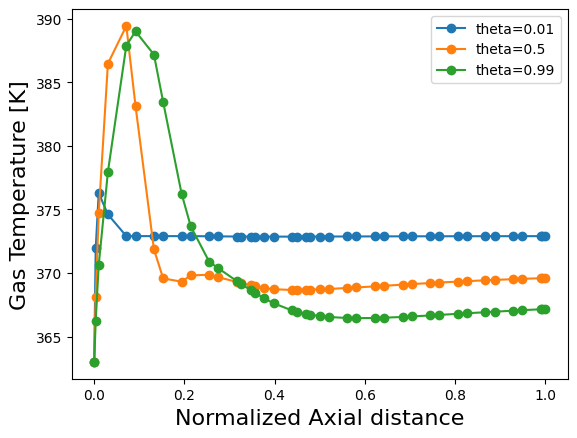

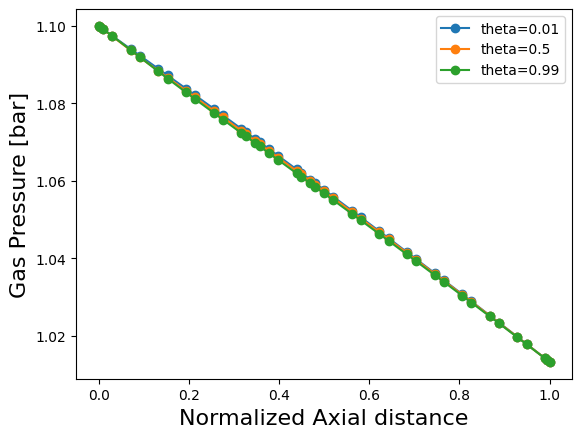

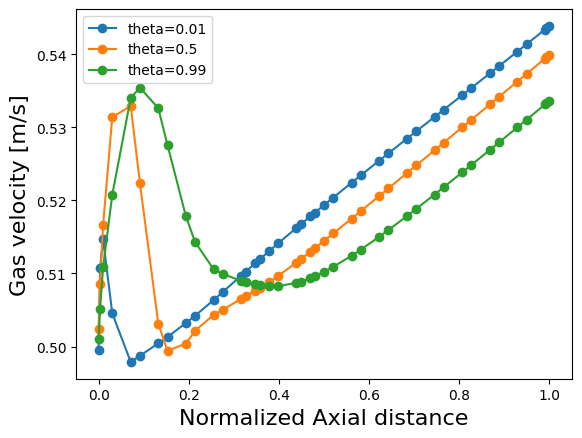

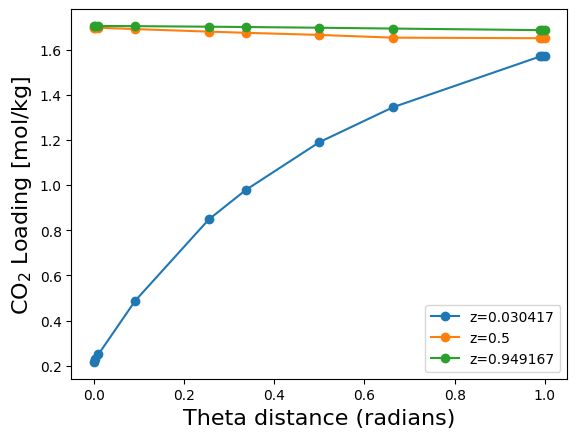

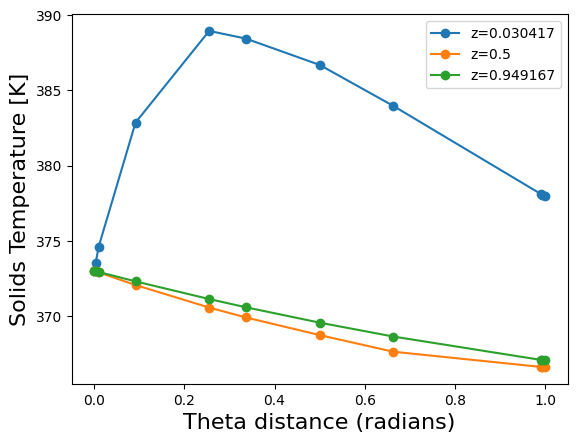

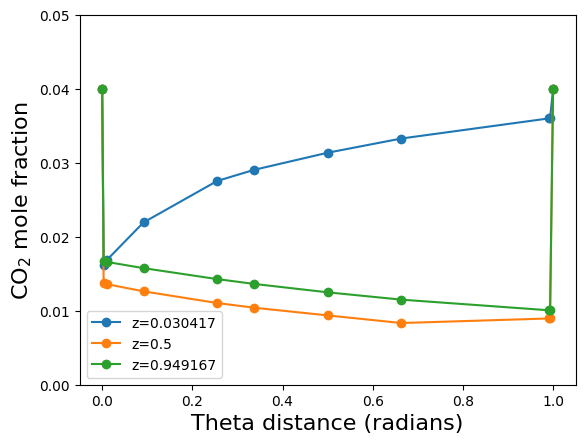

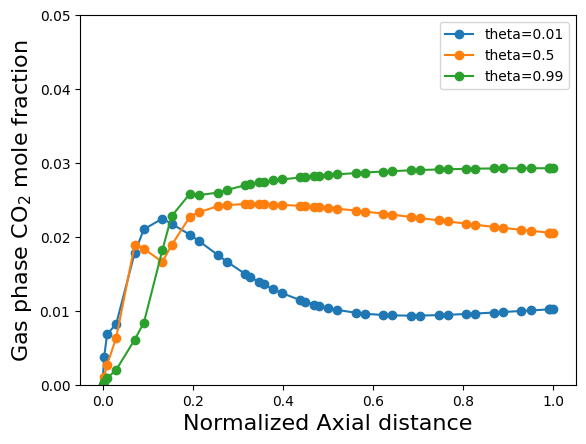

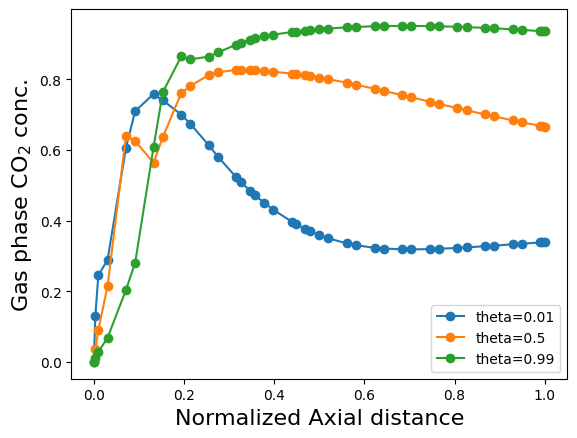

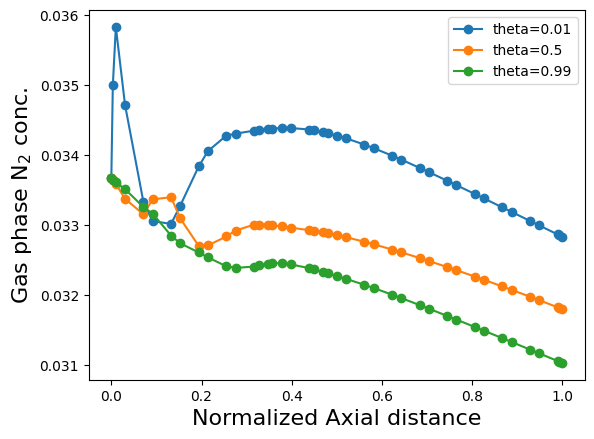

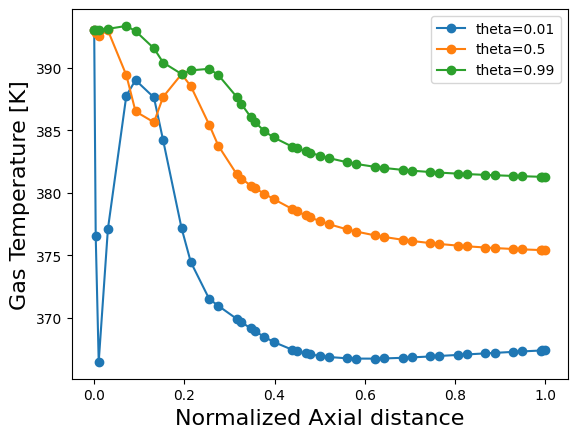

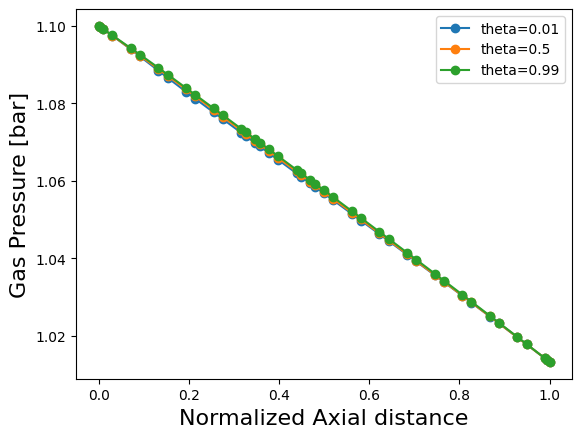

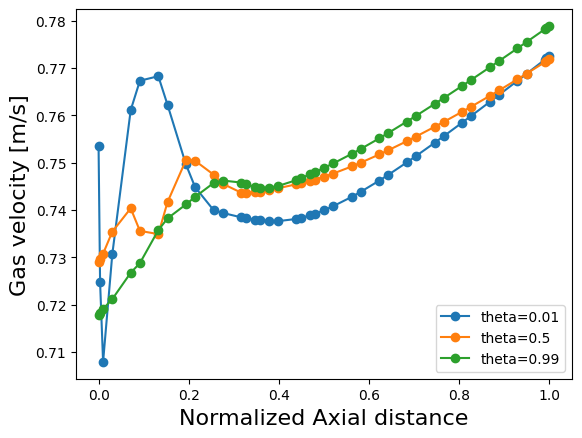

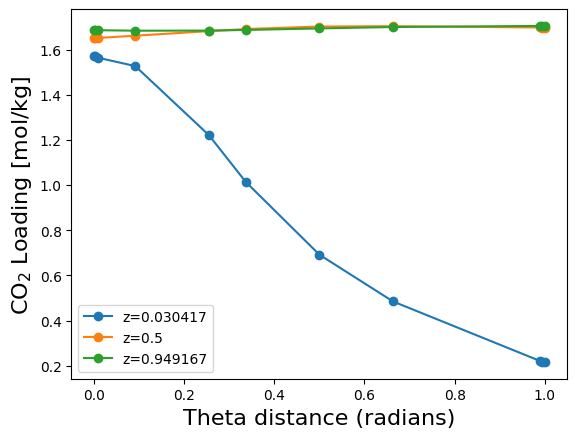

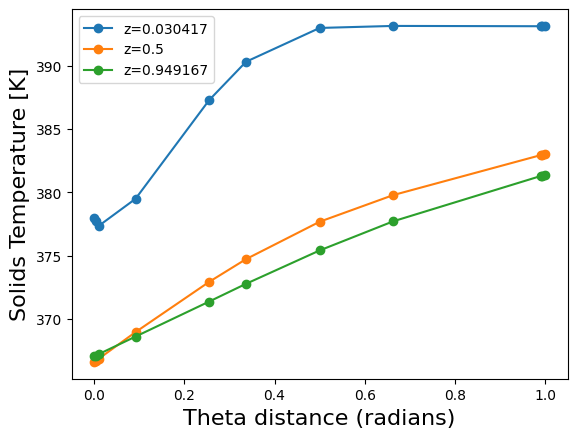

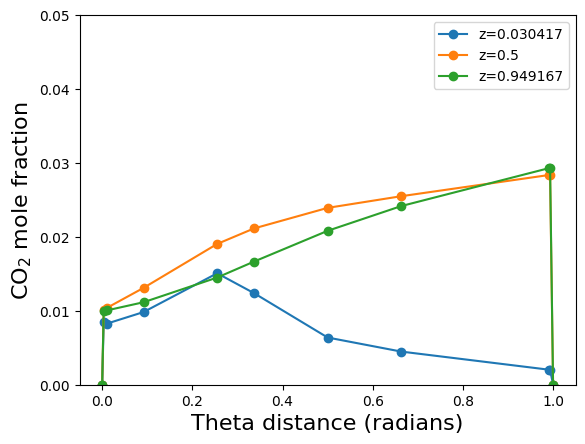

In [25]:
# plotting results

plotting(RPB.ads)

# and/or 

plotting(RPB.des)